In [34]:
import numpy as np
import pandas as pd
np.random.seed(10)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1200


In [65]:
df = pd.read_csv('Stress-Rfa.csv')
df.head(5)

,u,v,weight,sign,SIP,SIN,SDP,SDN,Uncommon,SIPV,SINV,SDPV,SDNV,UncommonV
0,5936.0,3589.0,0.0756,P,0,0,0,0,1,4,2,9,1,11
1,3589.0,3580.0,0.0348,P,4,2,9,1,11,1,0,10,0,13
2,3589.0,579.0,0.0365,P,4,2,9,1,11,0,0,0,0,1
3,3589.0,4047.0,-0.0024,N,4,2,9,1,11,0,0,1,0,2
4,3589.0,863.0,0.0193,P,4,2,9,1,11,0,3,2,0,1


In [66]:
n_estimator = 10
X = df[['SIP','SIN','SDP','SDN']]
y = df['sign']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


In [67]:
X_train, X_train_lr, y_train, y_train_lr = train_test_split(
    X_train, y_train, test_size=0.5)

In [68]:

# SGD
sgd = linear_model.SGDClassifier(max_iter=1000, tol=1e-3,loss = 'hinge')
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.decision_function(X_test)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_pred_sgd,pos_label='P')

In [69]:
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression(max_iter=1000)
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm,pos_label='P')


C:\Users\Pooria\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Pooria\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [70]:
# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(max_iter=1000)
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm,pos_label='P')

C:\Users\Pooria\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Pooria\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [71]:
# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd,pos_label='P')

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf,pos_label='P')

# The Adaboost by itself
adb = AdaBoostClassifier(n_estimators=100, random_state=0)
adb.fit(X_train, y_train)
y_pred_adb = adb.predict_proba(X_test)[:, 1]
fpr_adb, tpr_adb, _ = roc_curve(y_test, y_pred_adb,pos_label='P')

# The Adaboost by itself
clf1 = GradientBoostingClassifier()
clf2 = AdaBoostClassifier()
vt = VotingClassifier(estimators=[('abdt', clf1), ('gbdt', clf2)], voting='soft')
vt.fit(X_train, y_train)
y_pred_vt = vt.predict_proba(X_test)[:, 1]
fpr_vt, tpr_vt, _ = roc_curve(y_test, y_pred_vt,pos_label='P')


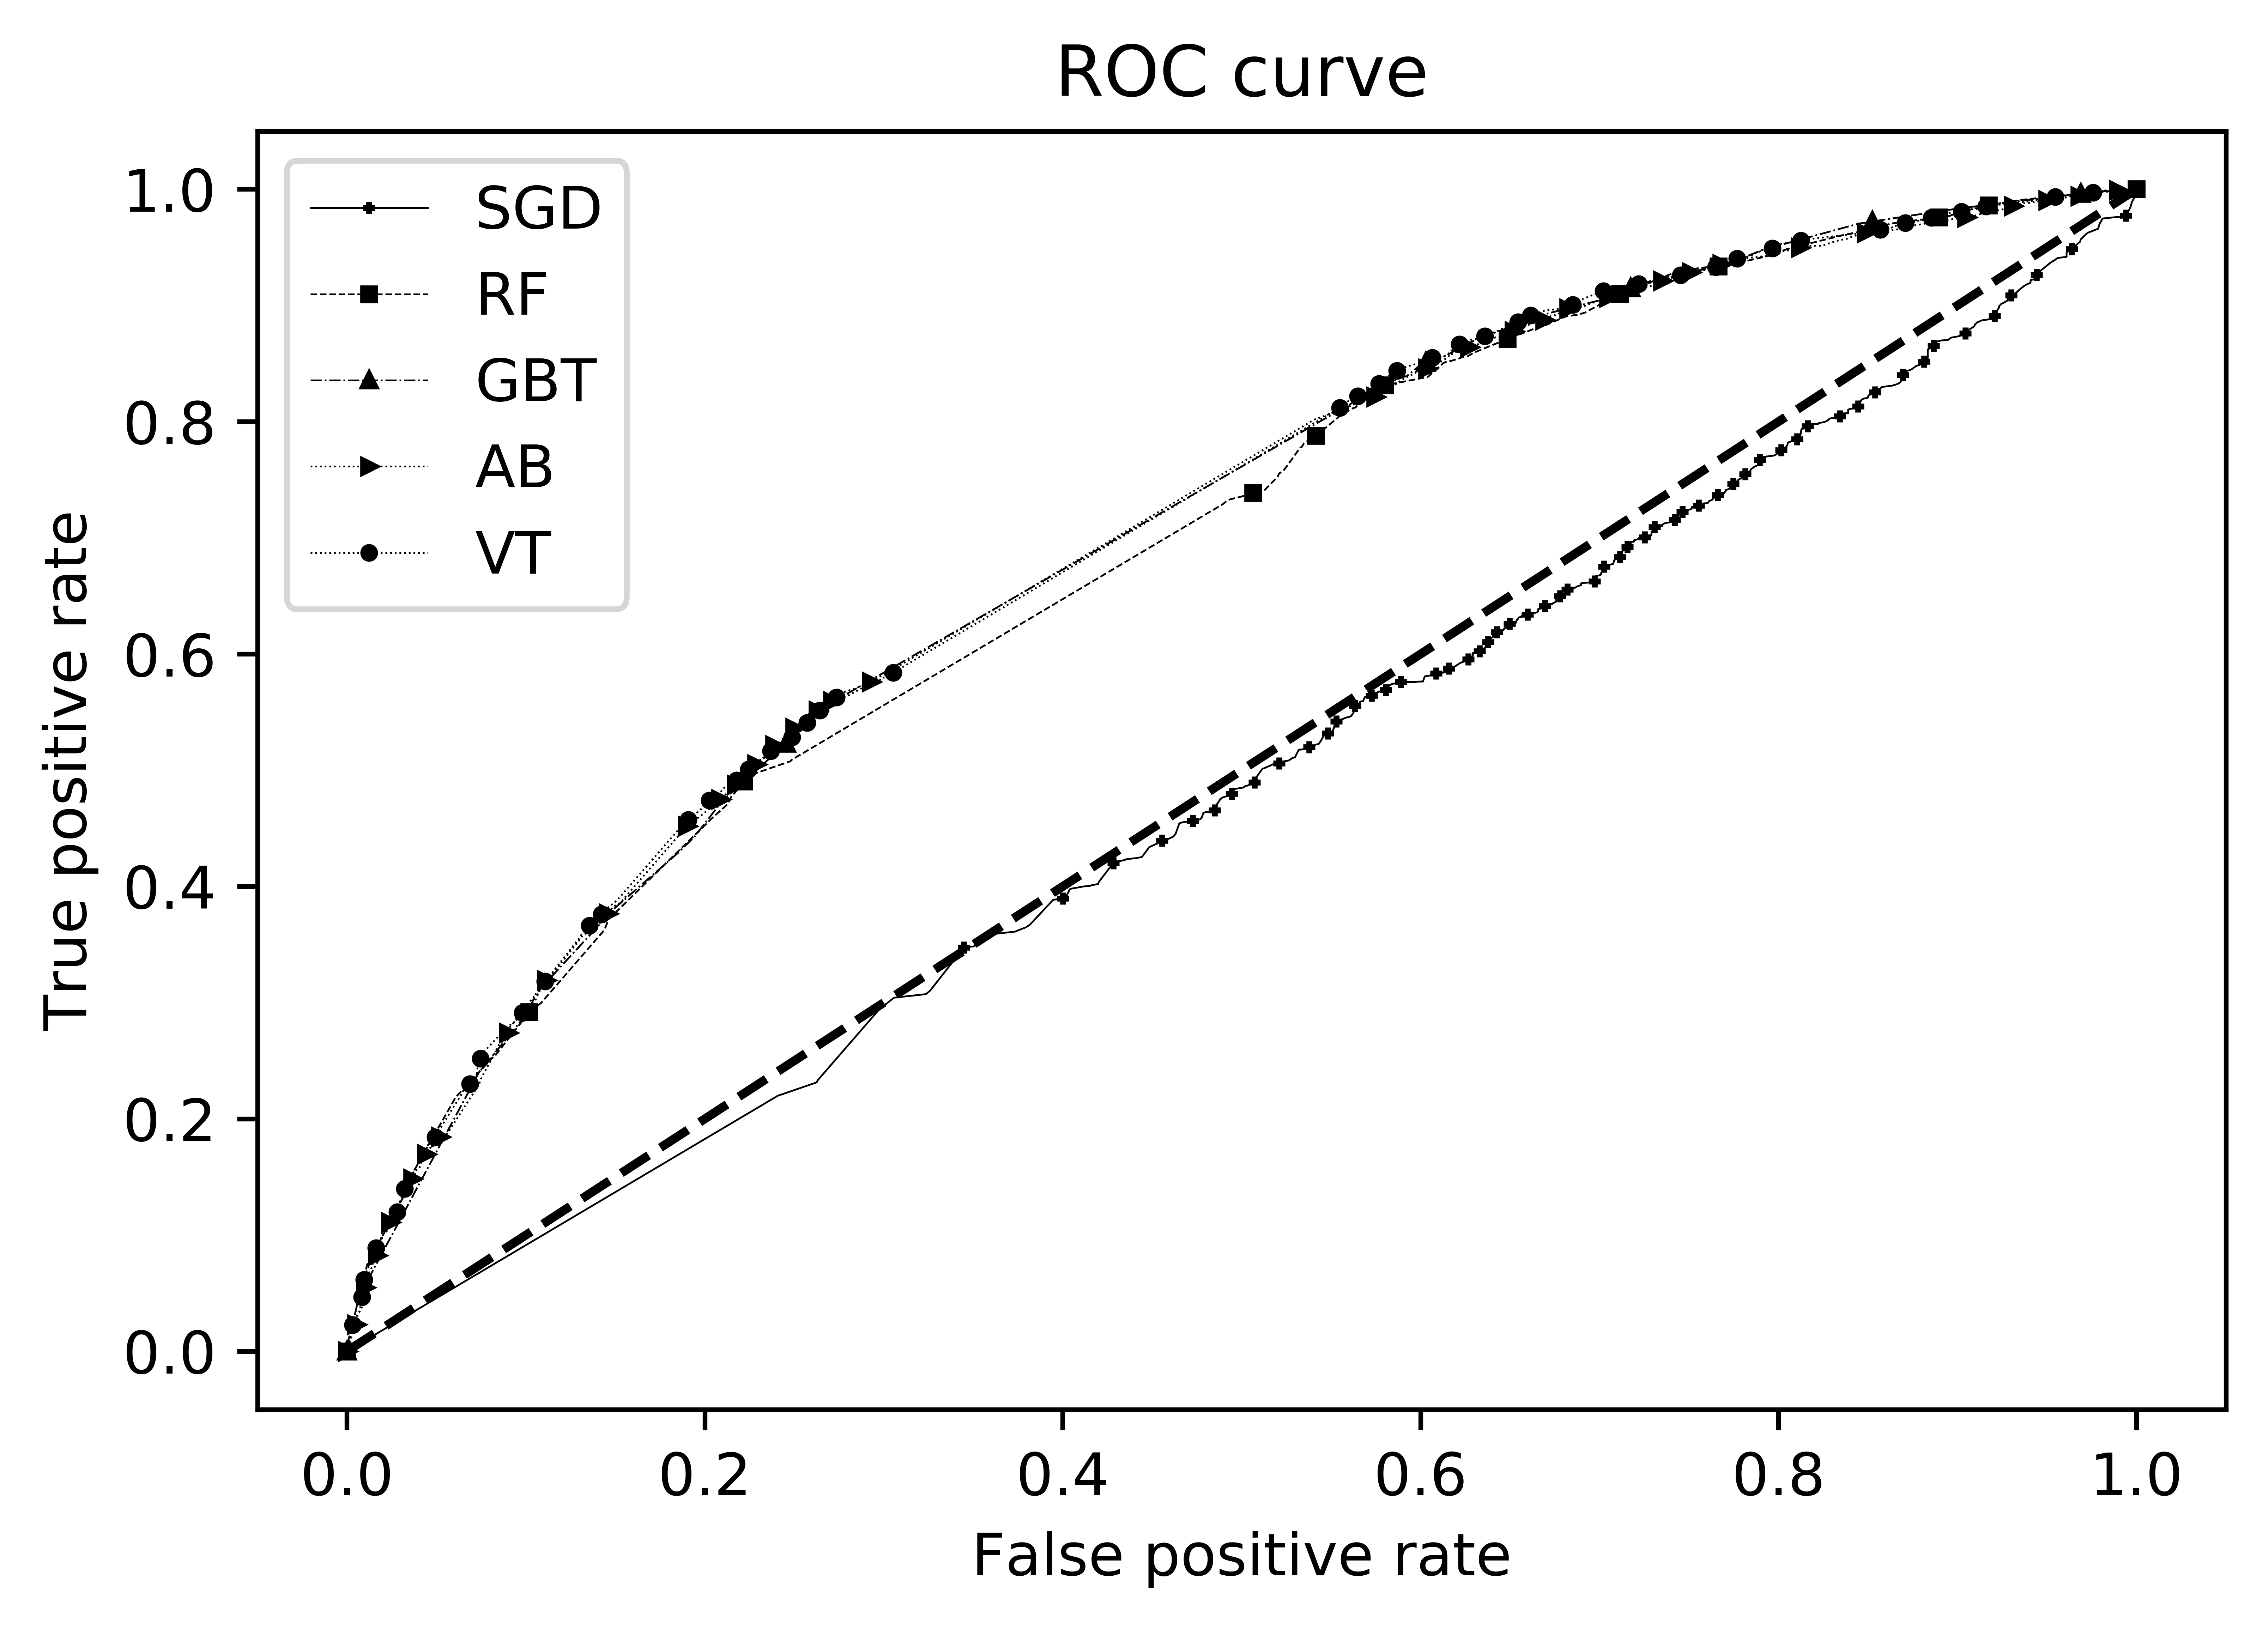

In [72]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_sgd, tpr_sgd,'+k-',markersize=2,markevery=10, label='SGD',linewidth=0.3)
plt.plot(fpr_rf, tpr_rf,"sk--",markersize=2,markevery=10, label='RF',linewidth=0.3)
plt.plot(fpr_grd, tpr_grd,"^k-.",markersize=2,markevery=10, label='GBT',linewidth=0.3)
plt.plot(fpr_adb, tpr_adb,">k:",markersize=2,markevery=10, label='AB',linewidth=0.3)
plt.plot(fpr_vt, tpr_vt,'ok:',markersize=2,markevery=10, label='VT',linewidth=0.3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

